In [1]:
import xarray as xr
import fsspec

## Install/Update packages and Load common functions

In [ ]:
# only run once, then restart session and comment the next 3 lines
!pip install s3fs -U
!pip install zarr xarray[complete] -U

In [3]:
# remote zarr dataset
dataset_name="srs_l3s_1d_dn"
url = f's3://imos-data-lab-optimised/cloud_optimised/cluster_testing/{dataset_name}.zarr/'
ds = xr.open_zarr(fsspec.get_mapper(url, anon=True), consolidated=True)
ds

<xarray.Dataset> Size: 119GB
Dimensions:                  (time: 50, lat: 4500, lon: 6000)
Coordinates:
  * lat                      (lat) float32 18kB 19.99 19.97 ... -69.97 -69.99
  * lon                      (lon) float32 24kB 70.01 70.03 ... 190.0 190.0
  * time                     (time) datetime64[ns] 400B 2024-01-01T09:20:00 ....
Data variables:
    dt_analysis              (time, lat, lon) float64 11GB dask.array<chunksize=(5, 1000, 1000), meta=np.ndarray>
    l2p_flags                (time, lat, lon) float32 5GB dask.array<chunksize=(5, 1000, 1000), meta=np.ndarray>
    quality_level            (time, lat, lon) float32 5GB dask.array<chunksize=(5, 1000, 1000), meta=np.ndarray>
    satellite_zenith_angle   (time, lat, lon) float64 11GB dask.array<chunksize=(5, 1000, 1000), meta=np.ndarray>
    sea_surface_temperature  (time, lat, lon) float64 11GB dask.array<chunksize=(5, 1000, 1000), meta=np.ndarray>
    sses_bias                (time, lat, lon) float64 11GB dask.array<chunksize=(5, 1000, 1000), meta=np.ndarray>
    sses_count               (time, lat, lon) float64 11GB dask.array<chunksize=(5, 1000, 1000), meta=np.ndarray>
    sses_standard_deviation  (time, lat, lon) float64 11GB dask.array<chunksize=(5, 1000, 1000), meta=np.ndarray>
    sst_count                (time, lat, lon) float64 11GB dask.array<chunksize=(5, 1000, 1000), meta=np.ndarray>
    sst_dtime                (time, lat, lon) float64 11GB dask.array<chunksize=(5, 1000, 1000), meta=np.ndarray>
    sst_mean                 (time, lat, lon) float64 11GB dask.array<chunksize=(5, 1000, 1000), meta=np.ndarray>
    sst_standard_deviation   (time, lat, lon) float64 11GB dask.array<chunksize=(5, 1000, 1000), meta=np.ndarray>
Attributes: (12/47)
    Conventions:                CF-1.6
    Metadata_Conventions:       Unidata Dataset Discovery v1.0
    Metadata_Link:              TBA
    acknowledgment:             Any use of these data requires the following ...
    cdm_data_type:              grid
    comment:                    HRPT AVHRR experimental L3 retrieval produced...
    ...                         ...
    summary:                    Skin SST retrievals produced from stitching t...
    time_coverage_end:          20240210T163514Z
    time_coverage_start:        20240210T002953Z
    title:                      IMOS L3S Day and Night gridded multiple-senso...
    uuid:                       b21e26ac-1562-42b6-840b-43af2aa7c11b
    westernmost_longitude:      70.01000213623047

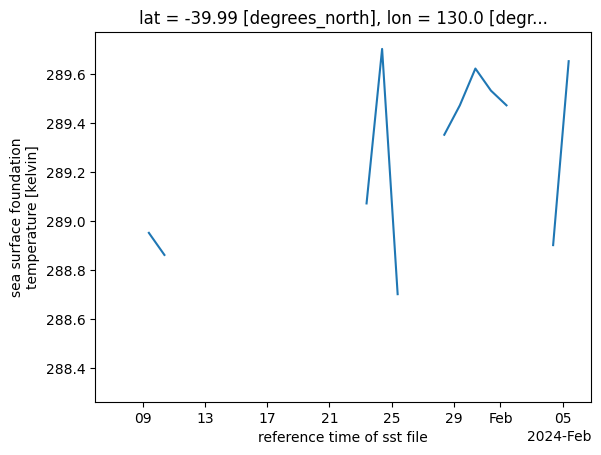

In [4]:
ds.sea_surface_temperature.sel(lat=-40, lon=130, method='nearest').plot()

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import traceback

def plot_sst(ds, start_date, lon_slice, lat_slice):
    """
    Plots SST data for 6 consecutive days starting from start_date.

    Parameters:
    - ds: xarray.Dataset containing the SST data.
    - start_date: str, start date in 'YYYY-MM-DD' format.
    - lon_slice: tuple, longitude slice (start_lon, end_lon).
    - lat_slice: tuple, latitude slice (start_lat, end_lat).
    """
    # Parse the start date
    start_date_parsed = pd.to_datetime(start_date)

    # Ensure the dataset has a time dimension and it's sorted
    assert 'time' in ds.dims, "Dataset does not have a 'time' dimension"
    ds = ds.sortby('time')
    
    # Find the nearest date in the dataset
    nearest_date = ds.sel(time=start_date_parsed, method='nearest').time
    
    # Get the index of the nearest date
    nearest_date_index = ds.time.where(ds.time == nearest_date, drop=True).squeeze().values
    
    # Find the position of the nearest date in the time array
    nearest_date_position = int((ds.time == nearest_date_index).argmax().values)
    
    # Get the next 6 date values including the nearest date
    dates = ds.time[nearest_date_position:nearest_date_position + 6].values
    dates = [pd.Timestamp(date) for date in dates]

    print(dates)
    # Create subplots
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
    axes = axes.flatten()

    # Plot SST for each date
    for ax, date in zip(axes, dates):
        try:
            sst_data_kelvin = ds.sea_surface_temperature.sel(time=date.strftime('%Y-%m-%d'), lon=slice(lon_slice[0], lon_slice[1]), lat=slice(lat_slice[0], lat_slice[1]))
            
            # Convert Kelvin to Celsius for plotting
            sst_data_celsius = sst_data_kelvin - 273.15

            sst_data_celsius.plot(ax=ax, cmap='coolwarm', cbar_kwargs={'label': 'SST (°C)'})  # Using 'coolwarm' colormap
            ax.set_title(date.strftime('%Y-%m-%d'))
        except KeyError:
            # Print traceback for the KeyError
            #traceback.print_exc()
            # Handle the case where data for a specific date is not available
            ax.set_title(f"No data for {date.strftime('%Y-%m-%d')}")
            ax.axis('off')

    # Adjust layout
    plt.tight_layout()
    plt.show()

[Timestamp('2024-01-02 09:20:00'), Timestamp('2024-01-03 09:20:00'), Timestamp('2024-01-04 09:20:00'), Timestamp('2024-01-05 09:20:00'), Timestamp('2024-01-06 09:20:00'), Timestamp('2024-01-07 09:20:00')]


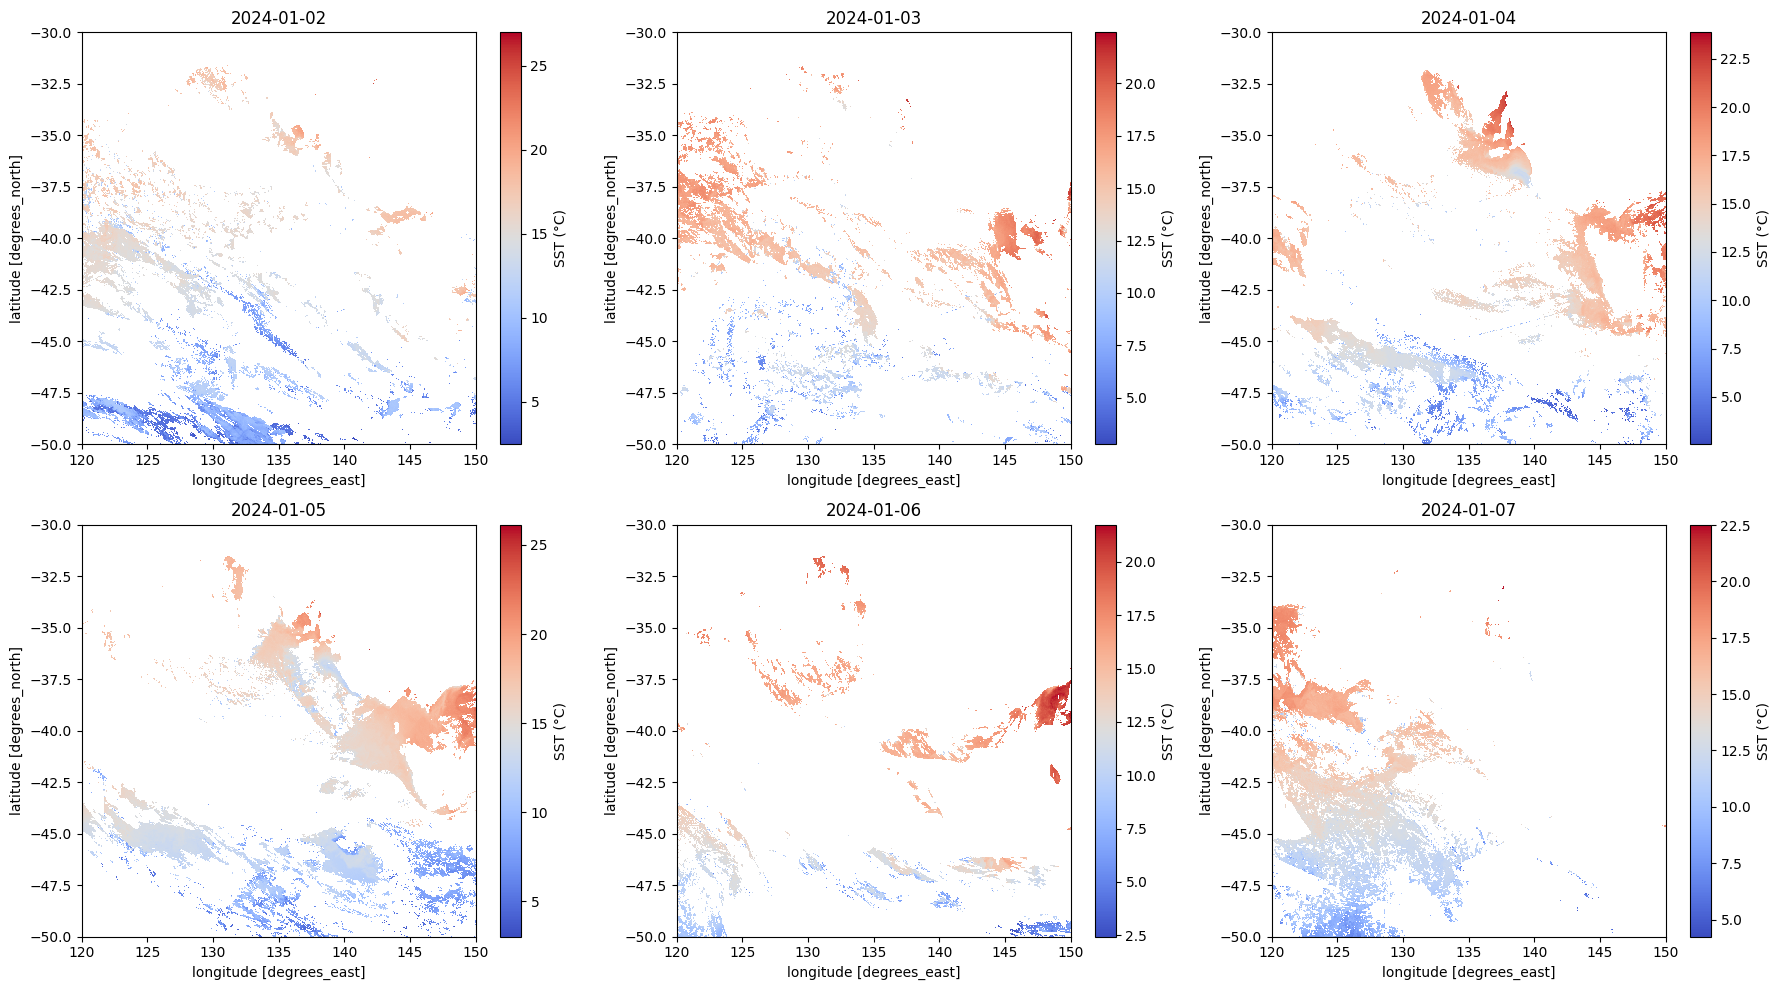

In [6]:
plot_sst(ds, start_date='2024-01-02', lon_slice=(120, 150), lat_slice=(-30, -50))